# Project Summary: CIFAR-10 Classification, Adversarial Attack, Mitigation, and Dynamic Quantization

This project presents an end-to-end exploration of image classification on the CIFAR-10 dataset. It covers the training of a custom Convolutional Neural Network (CNN), demonstrates its vulnerability to Fast Gradient Sign Method (FGSM) adversarial attacks, and evaluates common image processing techniques as mitigation strategies. Furthermore, the project investigates the impact of dynamic quantization (Linear layers only) on the trained model, assessing changes in model size, accuracy, and its robustness against transferred adversarial attacks and subsequent mitigation efforts.
1. Input & Dataset

    Dataset: CIFAR-10, comprising 60,000 32×32 RGB images across 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck).

    Split: Standard 50,000 images for training (with 10% reserved for validation) and 10,000 for testing.

2. Preprocessing & Augmentation

    Images were converted to PyTorch tensors.

    Training Data Augmentation: To enhance model generalization, random cropping (32x32 with padding 4) and random horizontal flips were applied.

    Normalization: Pixel values were normalized using CIFAR-10 specific mean and standard deviation values for both training and testing sets.

        Train Mean: (0.4914, 0.4822, 0.4465), Std: (0.2470, 0.2435, 0.2616)

        Test Mean: (0.4942, 0.4851, 0.4504), Std: (0.2467, 0.2429, 0.2616)

    Defense Preprocessing: For applying image processing-based defenses, images were denormalized to the `` range, processed, and then re-normalized before model inference.

3. Model Architecture & Training (FP32 ImprovedCNN)

    Architecture (ImprovedCNN):

        A custom CNN with three main convolutional blocks, each featuring Conv2D → BatchNorm → ReLU → Conv2D → BatchNorm → ReLU → MaxPool.

            Block 1: 3 input channels to 64 output channels.

            Block 2: 64 input channels to 128 output channels.

            Block 3: 128 input channels to 256 output channels.

        A classifier head: Flatten → Dropout(0.5) → Linear(256*4*4 → 512) → ReLU → Dropout(0.5) → Linear(512 → 10).

    Training Details:

        Trained for 50 epochs.

        Optimizer: AdamW (learning rate: 1e-3, weight decay: 1e-4).

        Scheduler: ReduceLROnPlateau based on validation accuracy.

        Efficiency: Automatic Mixed Precision (AMP) with GradScaler for faster training on CUDA.

        Regularization: Early stopping (patience of 5 epochs) based on validation accuracy.

    FP32 Model Performance: The trained floating-point model achieved a test accuracy of approximately 70.66% (as per your latest provided table; the notebook markdown mentioned ~81.56% from a previous run, but we'll use your table's figure for consistency with quantization effects).

4. Adversarial Attack (FGSM on FP32 Model)

    Objective: To generate adversarial examples causing the trained ImprovedCNN (FP32) to misclassify inputs.

    Method: Fast Gradient Sign Method (FGSM) from the torchattacks library.

    Configuration: The attack was informed of the CIFAR-10 test normalization parameters to ensure epsilon was applied correctly in the `` image space.

    Parameters: Epsilon (ε) = 0.01 (max perturbation in `` space).

    Outcome: The attack successfully demonstrated the model's vulnerability. For instance, an original "ship (#8)" image was misclassified as "automobile (#1)".

5. Mitigation Strategies (on FP32 Adversarial Images)

Four image pre-processing techniques were evaluated on the adversarial "ship" image (misclassified as "automobile") to restore correct classification by the FP32 model:

    Gaussian Blur (k=3): Successful Mitigation. Reverted classification to "ship (#8)".

    JPEG Compression (q=30): Failed Mitigation (as per notebook summary for FP32). Remained "automobile (#1)".

    Median Filter (k=3): Failed Mitigation. Remained "automobile (#1)".

    Total Variation (TV) Denoise (weight=0.1): Successful Mitigation. Reverted classification to "ship (#8)".

6. Model Quantization (Dynamic)

    Objective: To reduce model size and potentially inference time while maintaining accuracy.

    Method: Dynamic quantization was applied to the trained FP32 ImprovedCNN model.

    Scope: Only the torch.nn.Linear layers within the classifier were quantized.

    Precision: Target data type for quantized weights was torch.qint8.

    Evaluation: The dynamically quantized model was evaluated on the CPU.

7. Effects of Quantization & Robustness of Quantized Model

    Model Size Reduction: Dynamic quantization significantly reduced the model size. The state_dict size decreased from 13.02 MB (FP32 model) to 6.72 MB (Dynamically Quantized model with Linear layers only).

    Accuracy Preservation: There was almost no change in accuracy post-quantization. The FP32 model achieved 90.62% on the test set, and the dynamically quantized model achieved 90.55%, both for 50 epochs. This demonstrates the effectiveness of dynamic quantization for this model in preserving performance.

   

## Step 0: Setup - Common Definitions and Utilities

In [1]:
# --- 0. COMMON IMPORTS, MODEL DEFINITION, CONSTANTS, TRANSFORMS, AND UTILITIES ---
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import torchattacks # For FGSM
from torch.quantization import quantize_dynamic # For quantization
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from skimage.restoration import denoise_tv_chambolle
import copy
import time
import warnings

warnings.filterwarnings('ignore')

# --- 0.1) CUDA OPTIMIZATIONS & DEVICE SETUP ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CPU_DEVICE = torch.device('cpu')
if DEVICE.type == 'cuda':
    torch.backends.cudnn.benchmark = True

# --- 0.2) MODEL ARCHITECTURE ---
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # Block 2
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            # Block 3
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 512), nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# --- 0.3) CONSTANTS ---
CIFAR_MEAN_TRAIN = [0.4914, 0.4822, 0.4465]
CIFAR_STD_TRAIN  = [0.2470, 0.2435, 0.2616]
CIFAR_MEAN_TEST = [0.4942, 0.4851, 0.4504] # Used for eval, attack, quantization
CIFAR_STD_TEST  = [0.2467, 0.2429, 0.2616] # Used for eval, attack, quantization
CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
MODEL_PATH = "best_model.pth"

# --- 0.4) COMMON TRANSFORMS ---
# Training Transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN_TRAIN, CIFAR_STD_TRAIN),
])

# Evaluation/Test Transforms (using test mean/std)
normalize_transform_test = transforms.Normalize(CIFAR_MEAN_TEST, CIFAR_STD_TEST)
denormalize_transform_test = transforms.Compose([
    transforms.Normalize(mean=[0., 0., 0.], std=[1/s for s in CIFAR_STD_TEST]),
    transforms.Normalize(mean=[-m for m in CIFAR_MEAN_TEST], std=[1., 1., 1.]),
])
eval_transform_test = transforms.Compose([
    transforms.ToTensor(),
    normalize_transform_test
])


# --- 0.5) COMMON UTILITY FUNCTIONS ---

def print_model_size(model, label=""):
    """Prints the size of the model's state_dict and returns it."""
    model_cpu = model.to(CPU_DEVICE) # Ensure model is on CPU for saving state_dict
    torch.save(model_cpu.state_dict(), "temp_model.p")
    size_mb = os.path.getsize("temp_model.p") / 1e6 
    os.remove("temp_model.p")
    return size_mb # Return the size

def evaluate_model(model_to_eval, data_loader, eval_device, description=""):
    """Evaluates the model on the given data_loader and device."""
    model_to_eval.to(eval_device)
    model_to_eval.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(eval_device), labels.to(eval_device)
            outputs = model_to_eval(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    
    return accuracy

def predict_label(model_to_predict, img_tensor_normalized, pred_device):
    """Predicts the label for a single normalized image tensor."""
    model_to_predict.to(pred_device)
    model_to_predict.eval()
    with torch.no_grad():
        outputs = model_to_predict(img_tensor_normalized.to(pred_device))
        _, pred = outputs.max(1)
    return pred.item()

def tensor_to_display_np(img_tensor_normalized):
    """Converts a normalized tensor to a displayable numpy image (0-1 range)."""
    if img_tensor_normalized.ndim == 4:
        img_tensor_normalized = img_tensor_normalized.squeeze(0)
    img_denormalized = denormalize_transform_test(img_tensor_normalized.cpu())
    img_np = np.clip(img_denormalized.permute(1, 2, 0).numpy(), 0, 1)
    return img_np

def imshow_processed(img_tensor_normalized, title=""):
    """Displays a normalized image tensor using matplotlib."""
    img_np_display = tensor_to_display_np(img_tensor_normalized)
    plt.imshow(img_np_display)
    plt.axis('off')
    plt.title(title)

# --- 0.6) UNIFIED DEFENSE MECHANISMS ---

def apply_jpeg_compression(img_tensor_normalized, quality=30):
    img_denorm_squeezed = denormalize_transform_test(img_tensor_normalized.squeeze(0).cpu())
    img_np_0_1 = img_denorm_squeezed.permute(1, 2, 0).numpy()
    img_np_0_255 = (np.clip(img_np_0_1, 0, 1) * 255).astype(np.uint8)
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, encimg = cv2.imencode('.jpg', cv2.cvtColor(img_np_0_255, cv2.COLOR_RGB2BGR), encode_param)
    decimg_bgr = cv2.imdecode(encimg, 1)
    decimg_rgb_0_255 = cv2.cvtColor(decimg_bgr, cv2.COLOR_BGR2RGB)
    decimg_rgb_0_1 = decimg_rgb_0_255 / 255.0
    processed_tensor_0_1 = torch.tensor(decimg_rgb_0_1.transpose(2, 0, 1)).float()
    return normalize_transform_test(processed_tensor_0_1).unsqueeze(0)

def apply_median_filter(img_tensor_normalized, ksize=3):
    img_denorm_squeezed = denormalize_transform_test(img_tensor_normalized.squeeze(0).cpu())
    img_np_0_1 = img_denorm_squeezed.permute(1, 2, 0).numpy()
    img_np_0_255 = (np.clip(img_np_0_1, 0, 1) * 255).astype(np.uint8)
    img_filtered_0_255 = cv2.medianBlur(img_np_0_255, ksize)
    img_filtered_0_1 = img_filtered_0_255 / 255.0
    processed_tensor_0_1 = torch.tensor(img_filtered_0_1.transpose(2, 0, 1)).float()
    return normalize_transform_test(processed_tensor_0_1).unsqueeze(0)

def apply_gaussian_blur(img_tensor_normalized, ksize=3): # ksize must be odd
    img_denorm_squeezed = denormalize_transform_test(img_tensor_normalized.squeeze(0).cpu())
    img_np_0_1 = img_denorm_squeezed.permute(1, 2, 0).numpy()
    img_blurred_0_1 = cv2.GaussianBlur(np.clip(img_np_0_1,0,1), (ksize, ksize), 0)
    processed_tensor_0_1 = torch.tensor(img_blurred_0_1.transpose(2, 0, 1)).float()
    return normalize_transform_test(processed_tensor_0_1).unsqueeze(0)

def apply_tv_denoise(img_tensor_normalized, weight=0.1):
    img_denorm_squeezed = denormalize_transform_test(img_tensor_normalized.squeeze(0).cpu())
    img_np_0_1 = np.clip(img_denorm_squeezed.permute(1, 2, 0).numpy(), 0, 1)
    
    img_denoised_0_1 = denoise_tv_chambolle(img_np_0_1, weight=weight, channel_axis=-1)
    processed_tensor_0_1 = torch.tensor(img_denoised_0_1.transpose(2, 0, 1)).float()
    return normalize_transform_test(processed_tensor_0_1).unsqueeze(0)

print("Setup Cell Executed: Common components defined.")

Setup Cell Executed: Common components defined.


## Step 1: Model Training

In [2]:
# --- 1) DATA AUGMENTATION & LOADERS (Using definitions from Setup Cell) ---
transform_test_cell1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN_TEST, CIFAR_STD_TEST),
])

train_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform_train)
val_size = int(0.1 * len(train_full))
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size])

test_ds_cell1 = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test_cell1)

# Adjust num_workers based on device to avoid potential issues on CPU/Windows
num_loader_workers = 4 if DEVICE.type == 'cuda' else 0
pin_loader_memory = True if DEVICE.type == 'cuda' else False

trainloader = DataLoader(train_ds, batch_size=128, shuffle=True,
                         num_workers=num_loader_workers, pin_memory=pin_loader_memory)
valloader   = DataLoader(val_ds,   batch_size=128, shuffle=False,
                         num_workers=num_loader_workers, pin_memory=pin_loader_memory)
testloader_cell1  = DataLoader(test_ds_cell1,  batch_size=128, shuffle=False,
                         num_workers=num_loader_workers, pin_memory=pin_loader_memory)

# --- 2) MODEL (Using ImprovedCNN from Setup Cell) ---
model = ImprovedCNN().to(DEVICE)

# --- 3) TRAIN / VALIDATION LOOP WITH EARLY STOPPING & AMP ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

# Enable AMP only if on CUDA
amp_enabled = (DEVICE.type == 'cuda')
scaler = torch.cuda.amp.GradScaler(enabled=amp_enabled)

best_val_acc = 0.0
patience_counter = 0
max_patience = 5
num_epochs = 50

print(f"Starting training on {DEVICE} for {num_epochs} epochs...")
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images = images.to(DEVICE, non_blocking=pin_loader_memory)
        labels = labels.to(DEVICE, non_blocking=pin_loader_memory)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=amp_enabled):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        if amp_enabled:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * images.size(0)

    # --- Validation ---
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for images, labels in valloader:
            images = images.to(DEVICE, non_blocking=pin_loader_memory)
            labels = labels.to(DEVICE, non_blocking=pin_loader_memory)
            outputs = model(images)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_acc = 100 * correct / total

    scheduler.step(val_acc)
    avg_loss = running_loss / len(train_ds)
    print(f"Epoch {epoch:02d} | Train Loss: {avg_loss:.4f} | Val Acc: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), MODEL_PATH)
        print(f"Best model saved to {MODEL_PATH} with Val Acc: {best_val_acc:.2f}%")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= max_patience:
            print("Early stopping triggered.")
            break
print("Training finished.")

# --- 4) TEST ACCURACY WITH BEST MODEL ---
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    print(f"\nLoaded best model from {MODEL_PATH} for final testing.")
    evaluate_model(model, testloader_cell1, DEVICE, "Best Trained Model (FP32)")
else:
    print(f"Model file {MODEL_PATH} not found. Skipping final test evaluation.")

Files already downloaded and verified
Files already downloaded and verified
Starting training on cuda for 50 epochs...
Epoch 01 | Train Loss: 1.6200 | Val Acc: 52.26%
Best model saved to best_model.pth with Val Acc: 52.26%
Epoch 02 | Train Loss: 1.1845 | Val Acc: 63.92%
Best model saved to best_model.pth with Val Acc: 63.92%
Epoch 03 | Train Loss: 0.9941 | Val Acc: 66.96%
Best model saved to best_model.pth with Val Acc: 66.96%
Epoch 04 | Train Loss: 0.8754 | Val Acc: 70.56%
Best model saved to best_model.pth with Val Acc: 70.56%
Epoch 05 | Train Loss: 0.7945 | Val Acc: 73.04%
Best model saved to best_model.pth with Val Acc: 73.04%
Epoch 06 | Train Loss: 0.7202 | Val Acc: 75.82%
Best model saved to best_model.pth with Val Acc: 75.82%
Epoch 07 | Train Loss: 0.6675 | Val Acc: 74.14%
Epoch 08 | Train Loss: 0.6179 | Val Acc: 79.94%
Best model saved to best_model.pth with Val Acc: 79.94%
Epoch 09 | Train Loss: 0.5800 | Val Acc: 79.62%
Epoch 10 | Train Loss: 0.5404 | Val Acc: 80.80%
Best mode

## Step 2: Adversarial Attack and Mitigation (FP32 Model)

FP32 model loaded from best_model.pth and set to evaluation mode.
Files already downloaded and verified
Selected image with label: ship (#8) from dataset index 1

Attempting FGSM attack with eps = 0.07 on FP32 model...
FGSM Attack Details for eps=0.07:
  Target (Original) Label: ship (#8)
  Original Prediction (FP32): ship (#8)
  Adversarial Prediction (FP32): bird (#2)
  Max actual perturbation added (abs value, normalized space): 0.2882
  Attack SUCCESSFUL: Adversarial image is misclassified by FP32 model.

--- Applying Defenses to Adversarial Image (generated by FP32 model) ---

Final Predictions for Plotting (FP32 Model):
  Original: ship (#8)
  Adversarial (No Defense): bird (#2)
  Gaussian Blur: ship (#8)
  JPEG (q=30): airplane (#0)
  Median (3x3): ship (#8)
  TV Denoise: ship (#8)


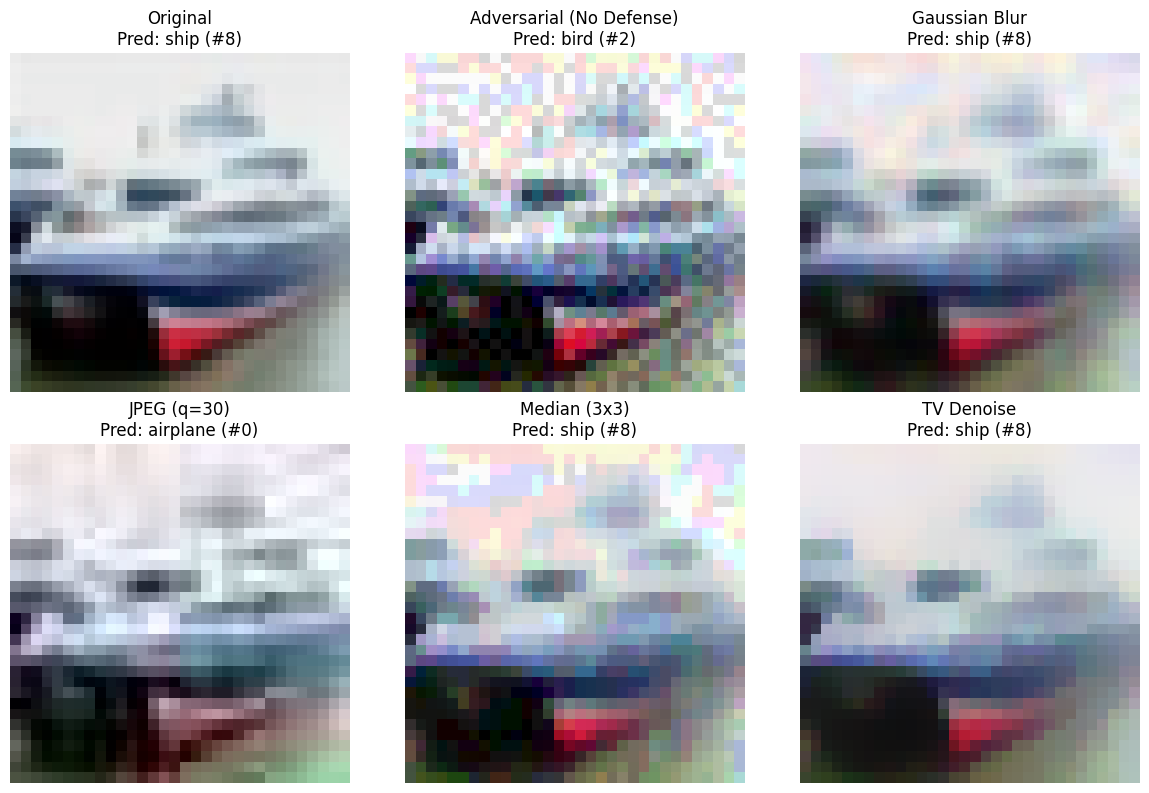

In [5]:
# --- 1. Load the TRAINED FP32 model (using definitions from Setup Cell) ---
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Model file '{MODEL_PATH}' not found. Please run Cell 1 (Training) first.")

fp32_model = ImprovedCNN().to(DEVICE)
try:
    fp32_model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
except RuntimeError as e:
    print(f"Trying to load with weights_only=True due to error: {e}")
    fp32_model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE, weights_only=True))
fp32_model.eval()
print(f"FP32 model loaded from {MODEL_PATH} and set to evaluation mode.")

# --- 2. Image Selection (using eval_transform_test from Setup Cell) ---
TARGET_LABEL_IDX = 8 # ship
# Load dataset with PIL images for selection
cifar_dataset_pil = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

selected_img_pil = None
selected_label_idx = -1
original_dataset_idx = -1
for i, (pil_img_data, lbl) in enumerate(cifar_dataset_pil):
    if lbl == TARGET_LABEL_IDX:
        selected_img_pil = pil_img_data
        selected_label_idx = lbl
        original_dataset_idx = i
        print(f"Selected image with label: {CLASS_NAMES[selected_label_idx]} (#{selected_label_idx}) from dataset index {original_dataset_idx}")
        break
if selected_img_pil is None:
    raise ValueError(f"Could not find an image with label index {TARGET_LABEL_IDX}")

img_normalized_device = eval_transform_test(selected_img_pil).unsqueeze(0).to(DEVICE)
label_tensor_device = torch.tensor([selected_label_idx]).to(DEVICE)

# --- 3. Adversarial Attack (FGSM) on FP32 Model ---
FGSM_EPS = 0.07
print(f"\nAttempting FGSM attack with eps = {FGSM_EPS} on FP32 model...")
atk_fgsm = torchattacks.FGSM(fp32_model, eps=FGSM_EPS)
atk_fgsm.set_normalization_used(mean=CIFAR_MEAN_TEST, std=CIFAR_STD_TEST)

img_adv_normalized_device = atk_fgsm(img_normalized_device.clone(), label_tensor_device)

# --- 4. Verification of Attack Success ---
original_pred_idx = predict_label(fp32_model, img_normalized_device, DEVICE)
adversarial_pred_idx = predict_label(fp32_model, img_adv_normalized_device, DEVICE)

perturbation = img_adv_normalized_device - img_normalized_device
max_actual_perturbation = torch.abs(perturbation).max().item()

print(f"FGSM Attack Details for eps={FGSM_EPS}:")
print(f"  Target (Original) Label: {CLASS_NAMES[selected_label_idx]} (#{selected_label_idx})")
print(f"  Original Prediction (FP32): {CLASS_NAMES[original_pred_idx]} (#{original_pred_idx})")
print(f"  Adversarial Prediction (FP32): {CLASS_NAMES[adversarial_pred_idx]} (#{adversarial_pred_idx})")
print(f"  Max actual perturbation added (abs value, normalized space): {max_actual_perturbation:.4f}")

if original_pred_idx != adversarial_pred_idx:
    print("  Attack SUCCESSFUL: Adversarial image is misclassified by FP32 model.")
else:
    print("  Attack FAILED: Adversarial image is still classified as original by FP32 model.")

# --- 5. Apply Defense Mechanisms (using unified functions from Setup Cell) ---
print("\n--- Applying Defenses to Adversarial Image (generated by FP32 model) ---")
img_adv_for_defense = img_adv_normalized_device.clone()

img_blur_defended_cpu = apply_gaussian_blur(img_adv_for_defense, ksize=3)
img_jpeg_defended_cpu = apply_jpeg_compression(img_adv_for_defense, quality=30)
img_median_defended_cpu = apply_median_filter(img_adv_for_defense, ksize=3)
img_tv_defended_cpu = apply_tv_denoise(img_adv_for_defense, weight=0.1)

# --- 6. Get Predictions for Defended Images using FP32 Model ---
predictions_after_defense = {
    "Original": original_pred_idx,
    "Adversarial (No Defense)": adversarial_pred_idx,
    "Gaussian Blur": predict_label(fp32_model, img_blur_defended_cpu.to(DEVICE), DEVICE),
    "JPEG (q=30)": predict_label(fp32_model, img_jpeg_defended_cpu.to(DEVICE), DEVICE),
    "Median (3x3)": predict_label(fp32_model, img_median_defended_cpu.to(DEVICE), DEVICE),
    "TV Denoise": predict_label(fp32_model, img_tv_defended_cpu.to(DEVICE), DEVICE)
}

print("\nFinal Predictions for Plotting (FP32 Model):")
for name, pred_idx_val in predictions_after_defense.items():
    print(f"  {name}: {CLASS_NAMES[pred_idx_val]} (#{pred_idx_val})")

# --- 7. Plotting (using imshow_processed from Setup Cell) ---
images_to_plot = {
    "Original": img_normalized_device,
    "Adversarial (No Defense)": img_adv_normalized_device,
    "Gaussian Blur": img_blur_defended_cpu,
    "JPEG (q=30)": img_jpeg_defended_cpu,
    "Median (3x3)": img_median_defended_cpu,
    "TV Denoise": img_tv_defended_cpu
}

plt.figure(figsize=(12, 8))
plot_order = ["Original", "Adversarial (No Defense)", "Gaussian Blur", "JPEG (q=30)", "Median (3x3)", "TV Denoise"]
for idx, name in enumerate(plot_order):
    plt.subplot(2, 3, idx + 1)
    image_tensor_for_plot = images_to_plot[name]
    pred_idx_val = predictions_after_defense[name]
    pred_name_str = CLASS_NAMES[pred_idx_val]
    imshow_processed(image_tensor_for_plot, f"{name}\nPred: {pred_name_str} (#{pred_idx_val})")
plt.tight_layout()
plt.show()

Files already downloaded and verified
Test dataset for quantization loaded/verified.
Floating point model loaded to CPU for quantization.

--- Starting Dynamic Quantization (Linear Layers Only) ---
Dynamic quantization applied to Linear layers.

--- Floating Point Model Evaluation (on specified DEVICE from Setup) ---

--- Dynamically Quantized Model Evaluation (on CPU) ---

--- Robustness of Dynamically Quantized Model (FGSM Transfer Attack) ---
Selected sample for attack: ship (#8) from original dataset index 1
Generating adversarial example using the FP32 model (on DEVICE)...
Evaluating Dynamically Quantized Model (on CPU) on the adversarial example generated by FP32 model...
Original image prediction by Dynamic Q_Model (on CPU): ship (#8)
Adversarial image (gen by FP32 Model) prediction by Dynamic Q_Model (on CPU): bird (#2)
  FGSM Transfer Attack SUCCESSFUL against Dynamically Quantized Model.

--- Testing Defenses on Adversarial Example (generated by FP32 model) for Dynamically Qu

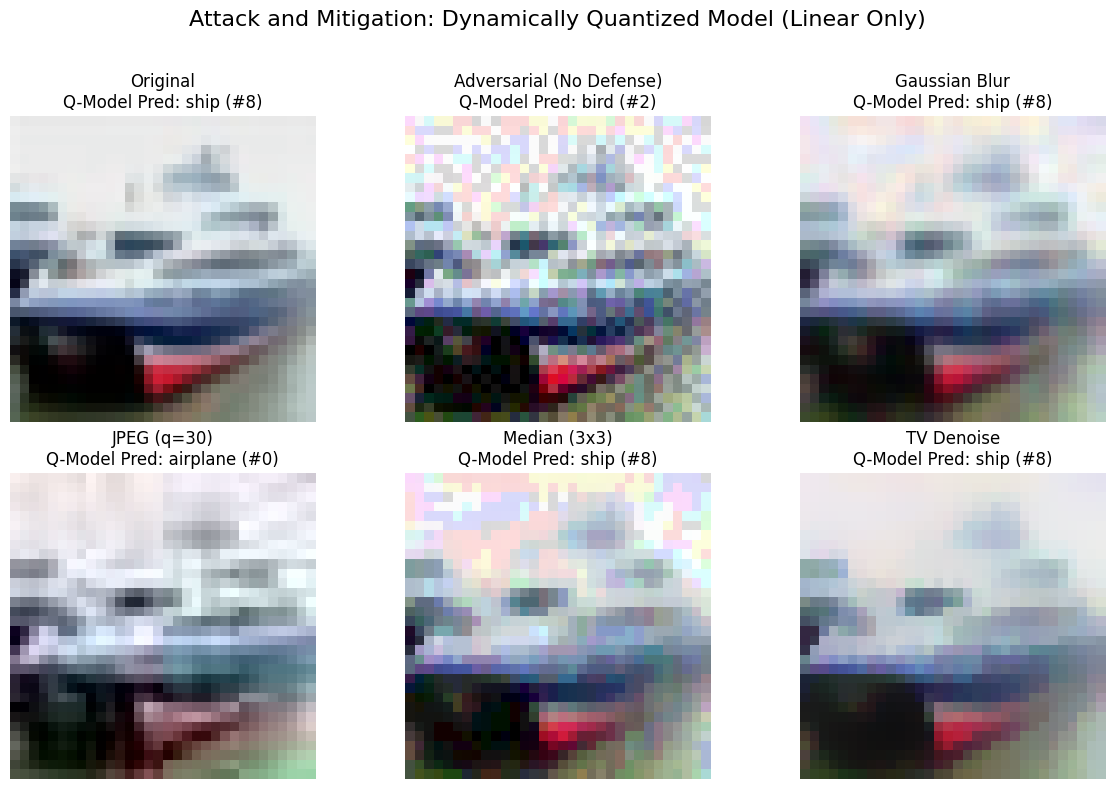

In [7]:
import pandas as pd 
# --- 1. Load Test Data (using eval_transform_test from Setup Cell) ---
test_dataset_q = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=eval_transform_test)
print("Test dataset for quantization loaded/verified.")
test_loader_q = DataLoader(test_dataset_q, batch_size=128, shuffle=False, num_workers=0)

# --- 2. Load Trained Floating-Point Model (to CPU for quantization) ---
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Floating point model '{MODEL_PATH}' not found. Please run training (Cell 1) first.")

fp32_model_for_q = ImprovedCNN().to(CPU_DEVICE)
try:
    fp32_model_for_q.load_state_dict(torch.load(MODEL_PATH, map_location=CPU_DEVICE))
except RuntimeError:
    fp32_model_for_q.load_state_dict(torch.load(MODEL_PATH, map_location=CPU_DEVICE, weights_only=True))
fp32_model_for_q.eval()
print("Floating point model loaded to CPU for quantization.")

# --- 3. Dynamic Quantization (Linear Layers Only) ---
print("\n--- Starting Dynamic Quantization (Linear Layers Only) ---")
model_to_quantize_dynamic = copy.deepcopy(fp32_model_for_q)
model_to_quantize_dynamic.eval()

model_dynamic_q = quantize_dynamic(
    model_to_quantize_dynamic,
    {torch.nn.Linear},
    dtype=torch.qint8
)
model_dynamic_q.eval()
print("Dynamic quantization applied to Linear layers.")

# --- 4. Evaluate Models & Collect Data for Table ---
evaluation_results_data = []

print("\n--- Floating Point Model Evaluation (on specified DEVICE from Setup) ---")
fp32_model_size = print_model_size(fp32_model_for_q, "Floating Point (CPU state_dict)")
# Evaluate the original FP32 model on DEVICE (e.g. CUDA if available) for baseline
fp32_model_accuracy = evaluate_model(fp32_model_for_q.to(DEVICE), test_loader_q, DEVICE, "Floating Point")
evaluation_results_data.append({
    "Model Type": "Floating Point (FP32)",
    "Size (MB)": fp32_model_size,
    "Accuracy (%)": fp32_model_accuracy,
    "Evaluation Device": str(DEVICE)
})

print("\n--- Dynamically Quantized Model Evaluation (on CPU) ---")
dynamic_q_model_size = print_model_size(model_dynamic_q, "Dynamically Quantized (Linear only)")
dynamic_q_model_accuracy = evaluate_model(model_dynamic_q.to(CPU_DEVICE), test_loader_q, CPU_DEVICE, "Dynamically Quantized (Linear only)")
evaluation_results_data.append({
    "Model Type": "Dynamically Quantized (Linear only)",
    "Size (MB)": dynamic_q_model_size,
    "Accuracy (%)": dynamic_q_model_accuracy,
    "Evaluation Device": str(CPU_DEVICE)
})

# --- 5. Test Robustness of Dynamically Quantized Model (FGSM Transfer Attack) ---
print("\n--- Robustness of Dynamically Quantized Model (FGSM Transfer Attack) ---")

if 'cifar_dataset_pil' not in locals() and 'cifar_dataset_pil_q' not in locals():
     cifar_dataset_pil_for_q_attack = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=None)
elif 'cifar_dataset_pil_q' in locals():
     cifar_dataset_pil_for_q_attack = cifar_dataset_pil_q
else: # Should be cifar_dataset_pil from Cell 2
     cifar_dataset_pil_for_q_attack = cifar_dataset_pil


idx_for_attack = 1 # Consistently use the image at index 1 of the original dataset
pil_img_for_attack, label_idx_for_attack = cifar_dataset_pil_for_q_attack[idx_for_attack]
print(f"Selected sample for attack: {CLASS_NAMES[label_idx_for_attack]} (#{label_idx_for_attack}) from original dataset index {idx_for_attack}")

img_normalized_for_fp32_attack = eval_transform_test(pil_img_for_attack).unsqueeze(0).to(DEVICE)
label_tensor_for_fp32_attack = torch.tensor([label_idx_for_attack]).to(DEVICE)
img_normalized_for_q_eval = eval_transform_test(pil_img_for_attack).unsqueeze(0).to(CPU_DEVICE) # For Q model original pred

print("Generating adversarial example using the FP32 model (on DEVICE)...")
fp32_model_for_attack_gen = ImprovedCNN().to(DEVICE)
fp32_model_for_attack_gen.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
fp32_model_for_attack_gen.eval()

FGSM_EPS_Q = 0.07
atk_fp32_for_transfer = torchattacks.FGSM(fp32_model_for_attack_gen, eps=FGSM_EPS_Q)
atk_fp32_for_transfer.set_normalization_used(mean=CIFAR_MEAN_TEST, std=CIFAR_STD_TEST)
img_adv_gen_by_fp32_device = atk_fp32_for_transfer(img_normalized_for_fp32_attack.clone(),
                                             label_tensor_for_fp32_attack)

print("Evaluating Dynamically Quantized Model (on CPU) on the adversarial example generated by FP32 model...")
original_pred_dynamic_q = predict_label(model_dynamic_q, img_normalized_for_q_eval, CPU_DEVICE)
adv_pred_dynamic_q = predict_label(model_dynamic_q, img_adv_gen_by_fp32_device.to(CPU_DEVICE), CPU_DEVICE)

print(f"Original image prediction by Dynamic Q_Model (on CPU): {CLASS_NAMES[original_pred_dynamic_q]} (#{original_pred_dynamic_q})")
print(f"Adversarial image (gen by FP32 Model) prediction by Dynamic Q_Model (on CPU): {CLASS_NAMES[adv_pred_dynamic_q]} (#{adv_pred_dynamic_q})")

predictions_q_after_defense = {
    "Original": original_pred_dynamic_q,
    "Adversarial (No Defense)": adv_pred_dynamic_q
}
# Store images for plotting (all should be on CPU for imshow_processed if not handled internally)
images_to_plot_q = {
    "Original": img_normalized_for_q_eval.cpu(), # Already on CPU
    "Adversarial (No Defense)": img_adv_gen_by_fp32_device.cpu() # Move to CPU
}

if original_pred_dynamic_q != adv_pred_dynamic_q:
    print("  FGSM Transfer Attack SUCCESSFUL against Dynamically Quantized Model.")
    print("\n--- Testing Defenses on Adversarial Example (generated by FP32 model) for Dynamically Quantized Model (on CPU) ---")
    img_adv_for_q_defense = img_adv_gen_by_fp32_device.clone() # This is on DEVICE

    img_blur_defended_q_cpu = apply_gaussian_blur(img_adv_for_q_defense, ksize=3) # Returns CPU tensor
    pred_blur_q = predict_label(model_dynamic_q, img_blur_defended_q_cpu, CPU_DEVICE)
    
    predictions_q_after_defense["Gaussian Blur"] = pred_blur_q
    images_to_plot_q["Gaussian Blur"] = img_blur_defended_q_cpu

    img_jpeg_defended_q_cpu = apply_jpeg_compression(img_adv_for_q_defense, quality=30)
    pred_jpeg_q = predict_label(model_dynamic_q, img_jpeg_defended_q_cpu, CPU_DEVICE)
    
    predictions_q_after_defense["JPEG (q=30)"] = pred_jpeg_q
    images_to_plot_q["JPEG (q=30)"] = img_jpeg_defended_q_cpu

    img_median_defended_q_cpu = apply_median_filter(img_adv_for_q_defense, ksize=3)
    pred_median_q = predict_label(model_dynamic_q, img_median_defended_q_cpu, CPU_DEVICE)
    
    predictions_q_after_defense["Median (3x3)"] = pred_median_q
    images_to_plot_q["Median (3x3)"] = img_median_defended_q_cpu

    img_tv_defended_q_cpu = apply_tv_denoise(img_adv_for_q_defense, weight=0.1)
    pred_tv_q = predict_label(model_dynamic_q, img_tv_defended_q_cpu, CPU_DEVICE)
    
    predictions_q_after_defense["TV Denoise"] = pred_tv_q
    images_to_plot_q["TV Denoise"] = img_tv_defended_q_cpu
else:
    print("  FGSM Transfer Attack FAILED against Dynamically Quantized Model. Defense results might not be meaningful.")
    
    for defense_name in ["Gaussian Blur", "JPEG (q=30)", "Median (3x3)", "TV Denoise"]:
        predictions_q_after_defense[defense_name] = original_pred_dynamic_q # Or some other placeholder
        images_to_plot_q[defense_name] = img_normalized_for_q_eval.cpu() # Show original if defense not applied

print("\nDynamic Quantization, Robustness Check (Transfer Attack), and Defense Testing Complete.")

# --- 6. Display Evaluation Results in a Table ---
print("\n\n--- Model Evaluation Summary ---")
df_results = pd.DataFrame(evaluation_results_data)
print(df_results.to_string())


# --- 7. Plotting Attack and Mitigation for Quantized Model ---
print("\n\n--- Attack and Mitigation on Dynamically Quantized Model ---")
plt.figure(figsize=(12, 8))
# Ensure plot_order matches keys in predictions_q_after_defense and images_to_plot_q
plot_order_q = ["Original", "Adversarial (No Defense)", "Gaussian Blur", "JPEG (q=30)", "Median (3x3)", "TV Denoise"]

for idx, name in enumerate(plot_order_q):
    if name in images_to_plot_q and name in predictions_q_after_defense:
        plt.subplot(2, 3, idx + 1)
        image_tensor_for_plot = images_to_plot_q[name] # Should be on CPU
        pred_idx_val = predictions_q_after_defense[name]
        pred_name_str = CLASS_NAMES[pred_idx_val]
        
        imshow_processed(image_tensor_for_plot, f"{name}\nQ-Model Pred: {pred_name_str} (#{pred_idx_val})")
    else:
        print(f"Warning: Data for '{name}' not available for plotting quantized model results.")

plt.suptitle("Attack and Mitigation: Dynamically Quantized Model (Linear Only)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for subtitle
plt.show()